In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras import regularizers
from keras import losses
from keras import optimizers

Using TensorFlow backend.


In [3]:
def read_signal(signal_number):
    x = pd.read_csv('RS_data/signals/s'+signal_number+'.csv').T.values[::, ::].astype(float)
    return x

In [4]:
a = pd.read_csv('RS_data/GT.csv')
a = a.T.values[::, ::].astype(float)
v = [0]*30
for i in range(1,31):
    z = read_signal(str(i))
    v[i-1] = z[0]



In [5]:
# m = 35366
# n = 50
# X = np.zeros([m, n])
# y = np.zeros([m, n])

# k = 0
# t = 0
# for i in range(30):
#     for j in range(0,v[i].shape[0], 5):
#         if(j+n < v[i].shape[0]):
#             X[k] = v[i][j:j+n]
#             for t in range(j, j+n):
#                 for s in range(20):
#                     if(s<20 and t==a[i][s]):
#                         y[k][t-j] = 1      
#             k = k+1

In [6]:
# m = 0;
# for i in range(30):
#     m +=int((v[i].shape[1]-n)/5) + 1
# print(m)

In [7]:
# plt.figure(figsize=(20,5))
# ax = plt.plot(v[0].T)
# plt.xlim(xmin=0)
# xcoords = a[0]
# for xc in xcoords:
#     plt.axvline(x=xc,color='red')

In [8]:


def constrainedCrossEntropy(ytrue, ypred):
  ypred = K.clip(ypred, 0.0001, 0.99999)
  return losses.categorical_crossentropy(ytrue, ypred)

In [9]:
# K.clear_session()

# model = Sequential()
# model.add(Dense(500, input_dim=n, activation='relu',kernel_regularizer=regularizers.l2(0.00001), bias_regularizer=regularizers.l2(0.00001)))
# model.add(Dense(n, activation='relu'))
# optimizer = optimizers.Adam(clipnorm=1., clipvalue=0.5)
# model.compile(loss=constrainedCrossEntropy, optimizer=optimizer)
# history = model.fit(X, y, epochs=2, batch_size=5, verbose=1, shuffle=False)

In [10]:
# for k in range(30):
#     plt.figure(figsize=(20,5))
#     ax = plt.plot(v[k].T)
#     plt.xlim(xmin=0)
#     xcoords = a[k]
#     for xc in xcoords:
#         plt.axvline(x=xc,color='red')
#     i = 0
#     while(i*10 < v[k].shape[1]):
#         s=0
#         for j in range(0,50,10):
#             s+=np.argmax(y_pred[i+j])
#         s = s/5
#         plt.axvline(x=s+i*10,color='black')
#         i += 50

# MAIN CODE 

In [11]:
n = 50
X = []
y = []

idx = []

for i in range(30):
    j = 0
    for s in range(a[i].shape[0]):
        while(j+n<a[i][s]):
            if(j+n<a[i][s] and (s==0 or j>a[i][max(s-1,0)])):
                X.append(v[i][j:j+n])
                idx.append((i,j))
                y.append(0)
            j = j+10
            
for i in range(30):
    for s in range(a[i].shape[0]):
        for j in range(int(a[i][s])-29, int(a[i][s])-19):
            X.append(v[i][j:j+n])
            idx.append((i,j))
            y.append(1)
#             print(str(j)+" "+str(j+n))
           
X = np.array(X)
y = np.array(y)

In [12]:
def accuracy(a_pred, a):
    r = 0
    w = 0
    flag = False
    for i in a_pred:
        flag = False
        for j in a:
            if((j >= i-50 and j <= i) or (j>=i and j<=i+50)):
                r += 1
                flag = True
                break
        if(flag == False):
            w += 1
    return r/(r+w)
        

In [22]:
K.clear_session()

model = Sequential()
model.add(Dense(100, input_dim=n, activation='relu'))
model.add(Dense(100, input_dim=n, activation='relu'))
model.add(Dense(100, input_dim=n, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(X, y, epochs=50, batch_size=1, verbose=1, shuffle=True)
model.save("trained_model(100,200,50)")

Epoch 1/50
20126/20126 [==============================] - 16s 800us/step - loss: 0.2981
Epoch 2/50
 9353/20126 [============>.................] - ETA: 8s - loss: 0.2964

KeyboardInterrupt: 

In [143]:
# model = load_model("trained_model")

In [15]:
y_pred = model.predict(X)


In [16]:
y_pred

array([[0.       ],
       [0.       ],
       [0.       ],
       ...,
       [0.9925978],
       [0.9572151],
       [0.9028708]], dtype=float32)

In [17]:
v_final = []
for i in range(30):
    v_final.append(np.zeros(v[i].shape[0]))
s=0;
for i in idx:
    j=int(i[0])
    k=int(i[1])
    if(y_pred[s] > 0.5):
        v_final[j][k+24] = y_pred[s]
    s=s+1
    
for i in range(30):
    for j in range(len(v_final[i])):
        if(v_final[i][j] != 0):
            l = max(j-50,0)
            r = min(j+50, len(v_final[i]))
            k = np.argmax(v_final[i][l:r])
            m = np.max(v_final[i][l:r])
            v_final[i][l:r] = 0
            v_final[i][l+k] = m


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


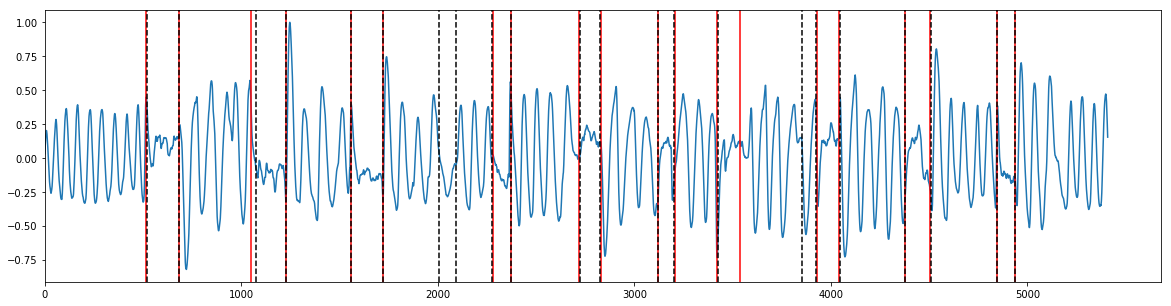

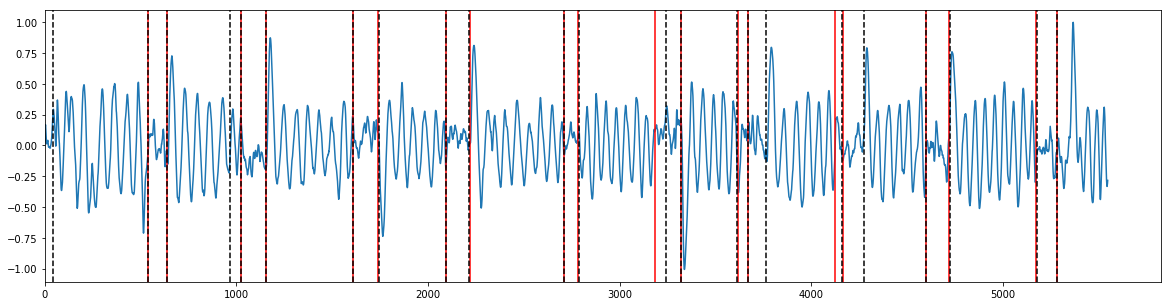

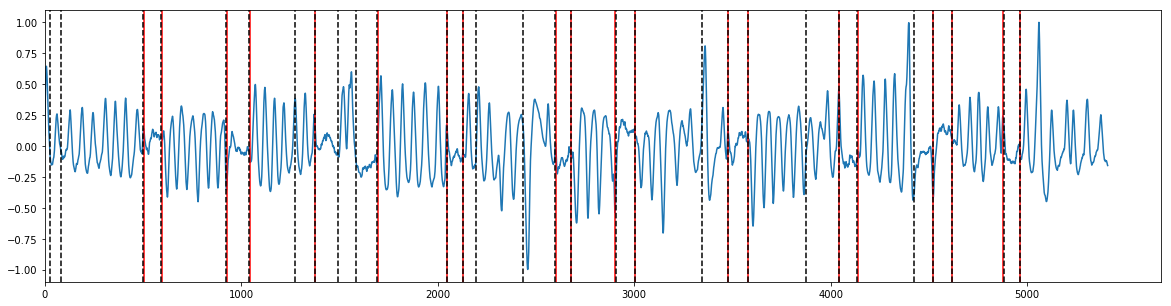

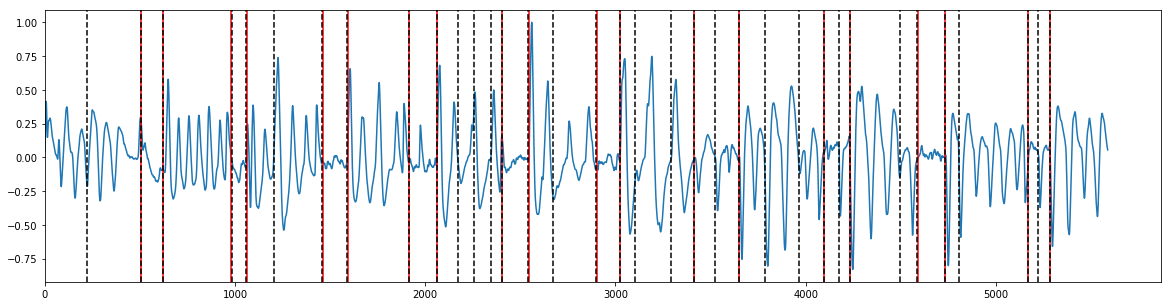

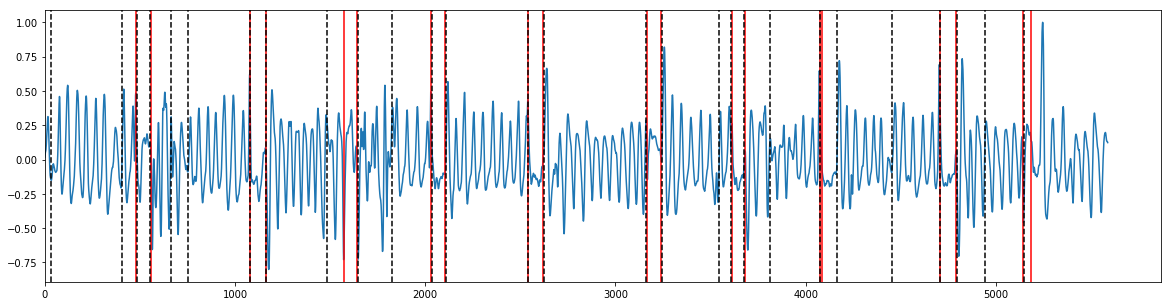

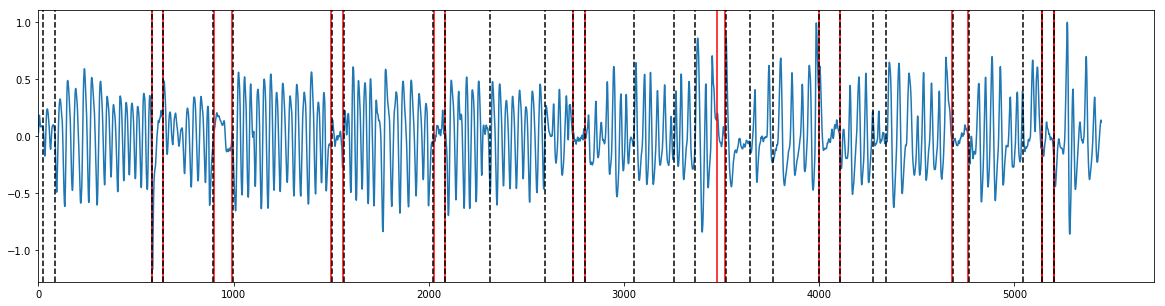

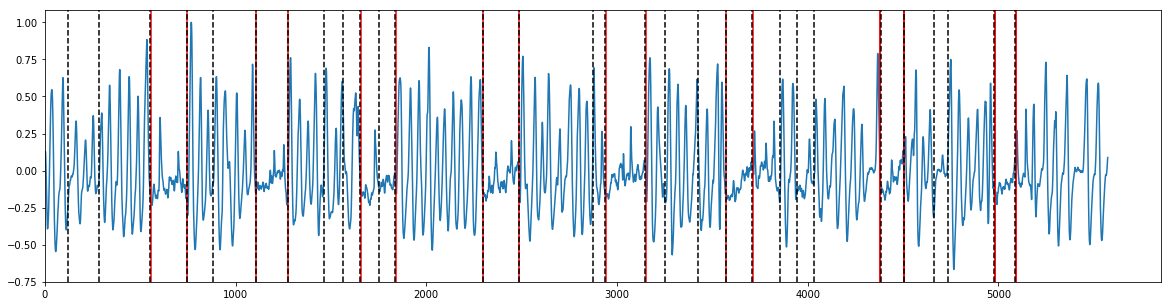

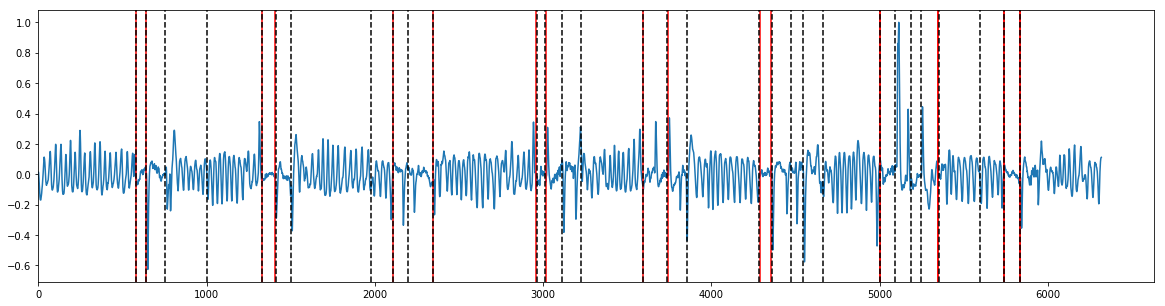

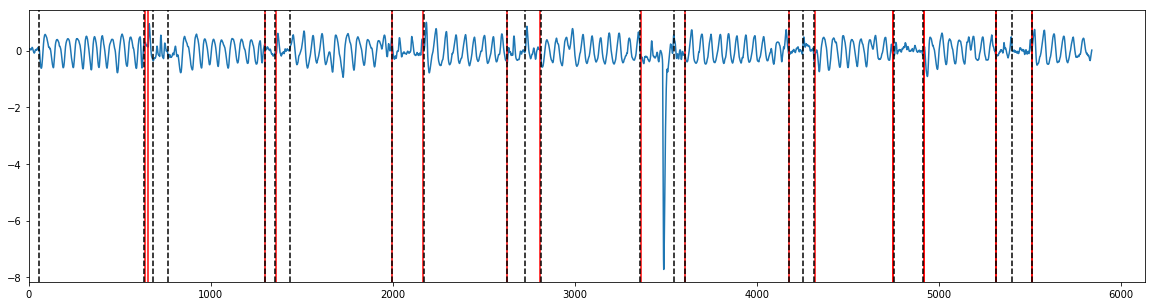

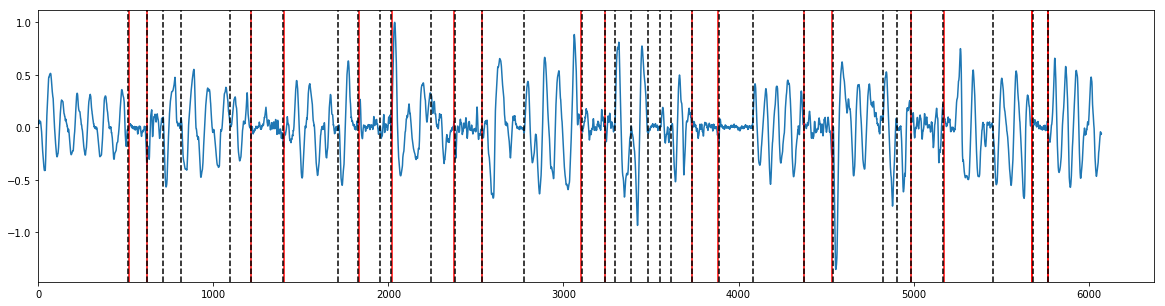

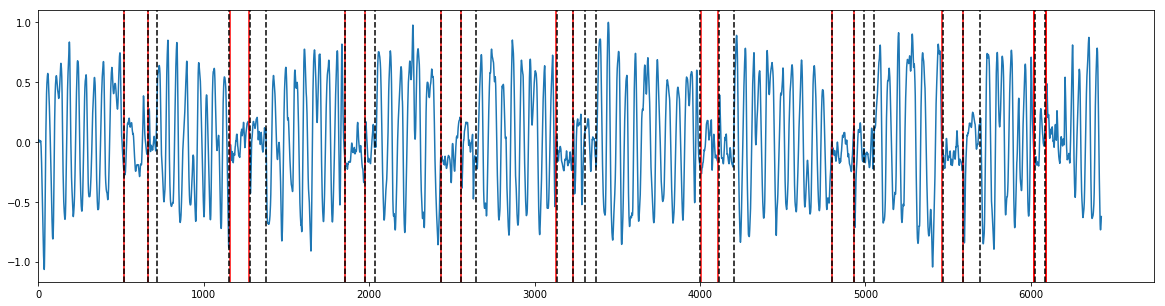

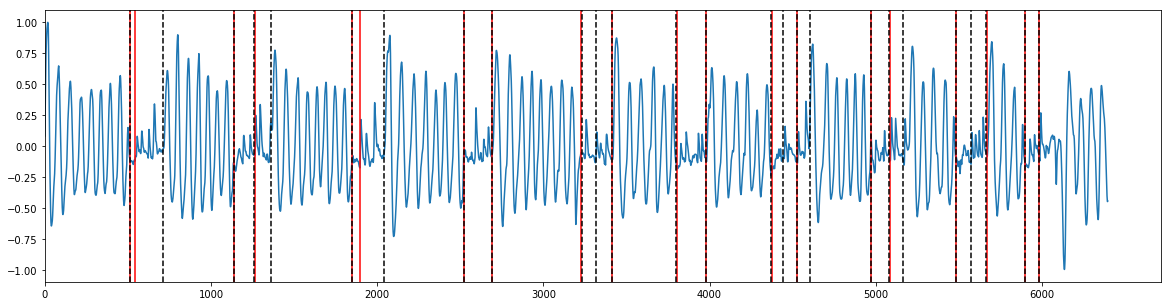

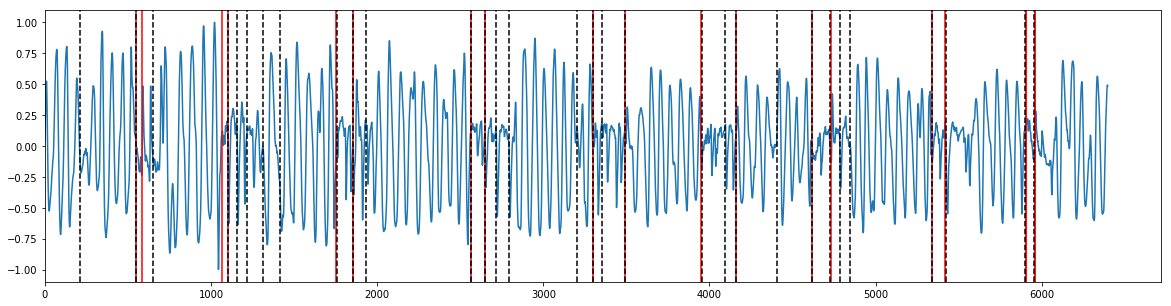

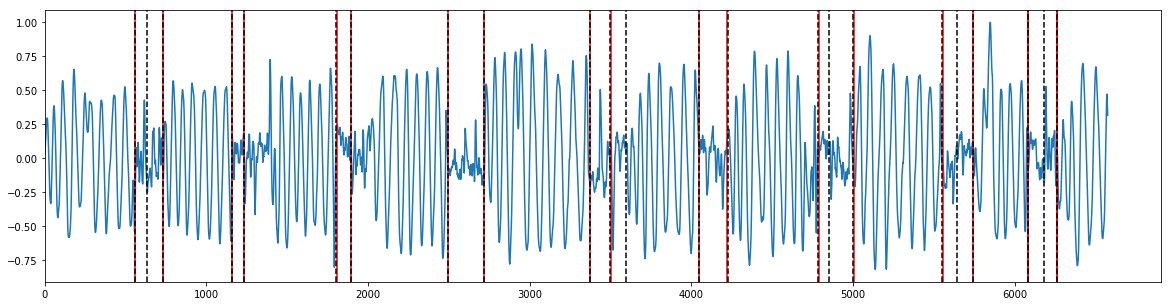

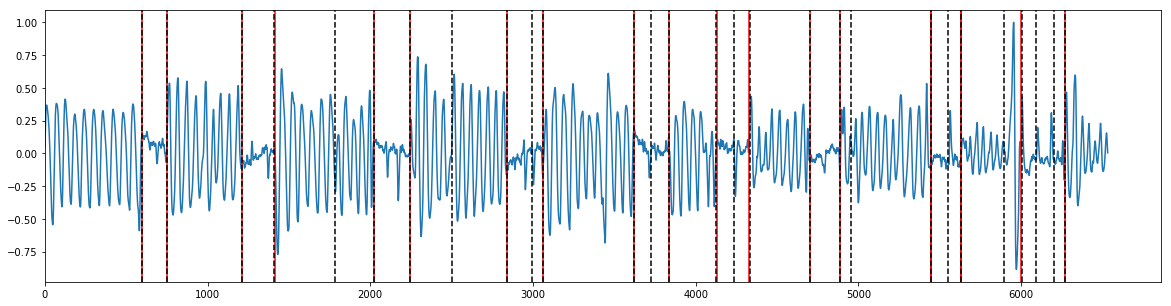

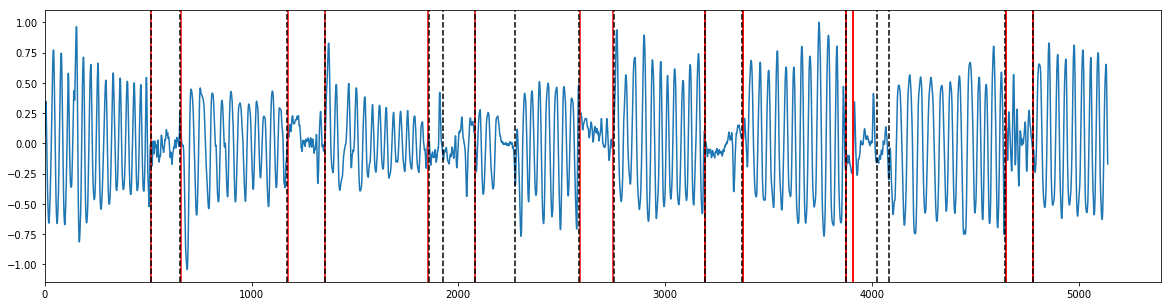

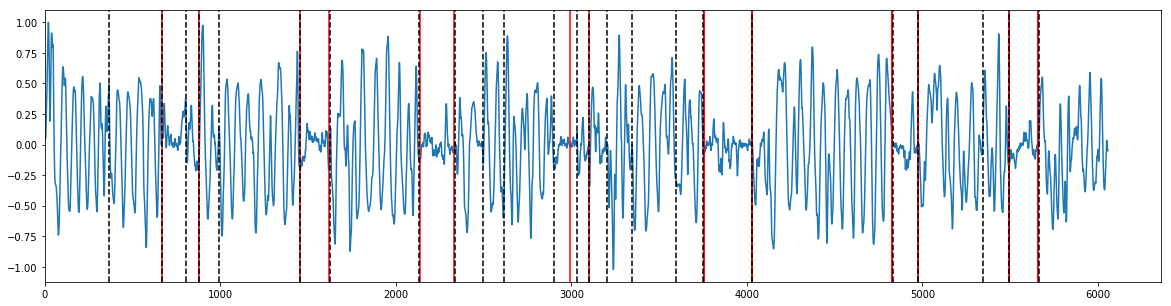

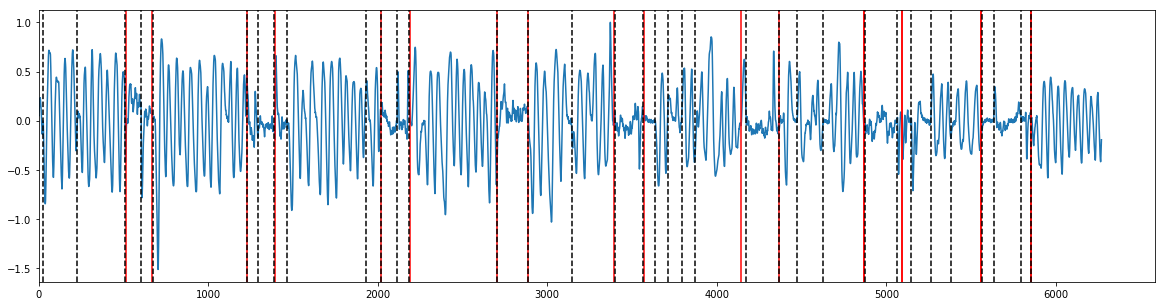

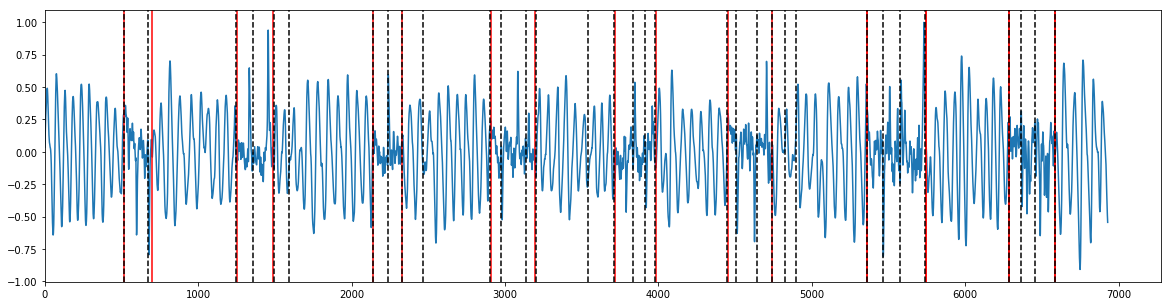

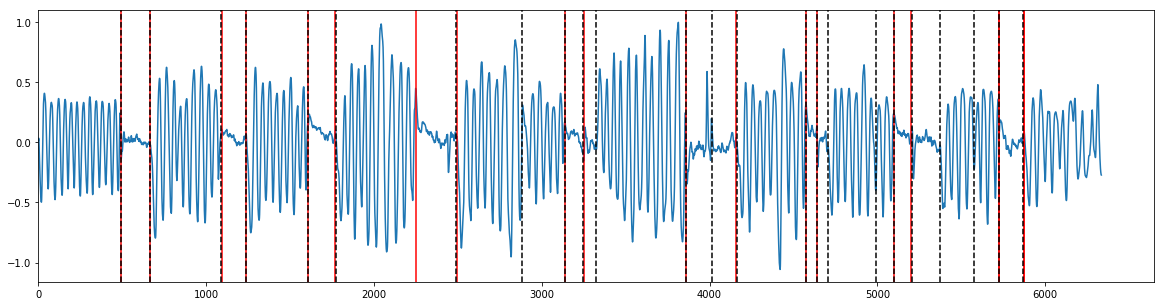

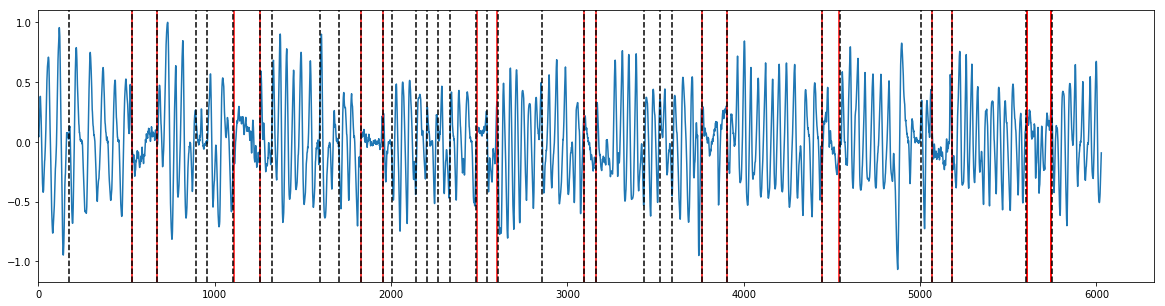

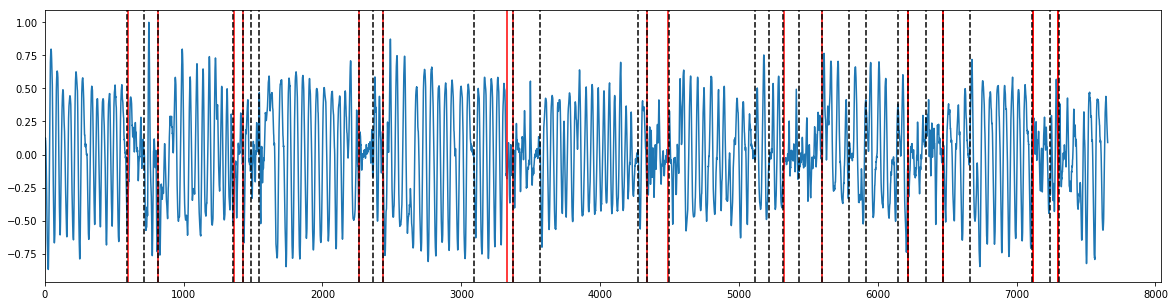

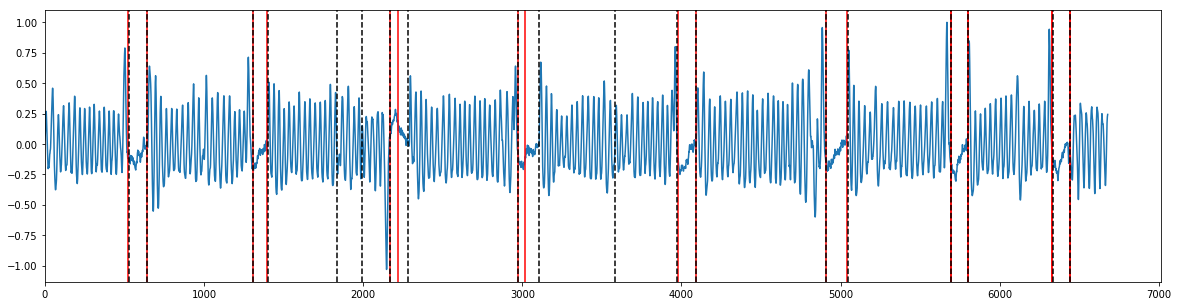

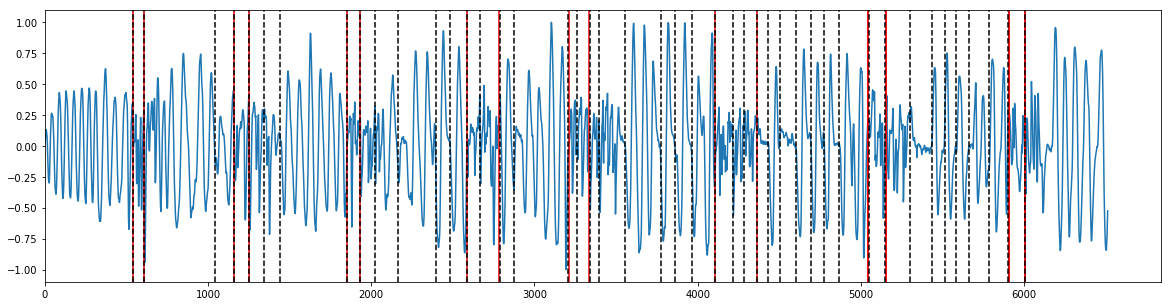

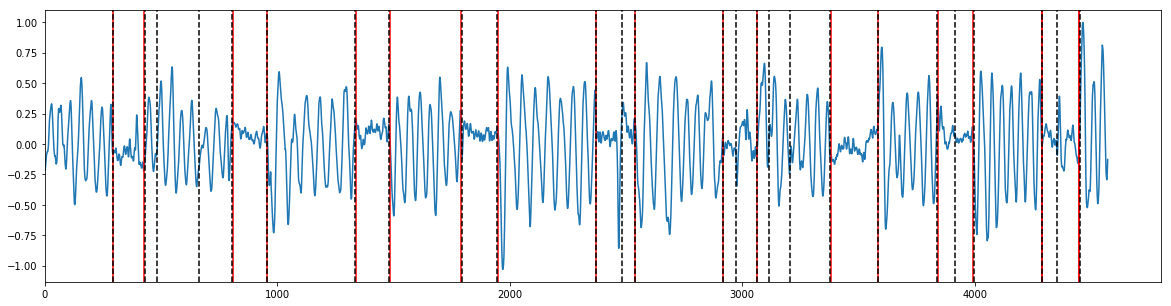

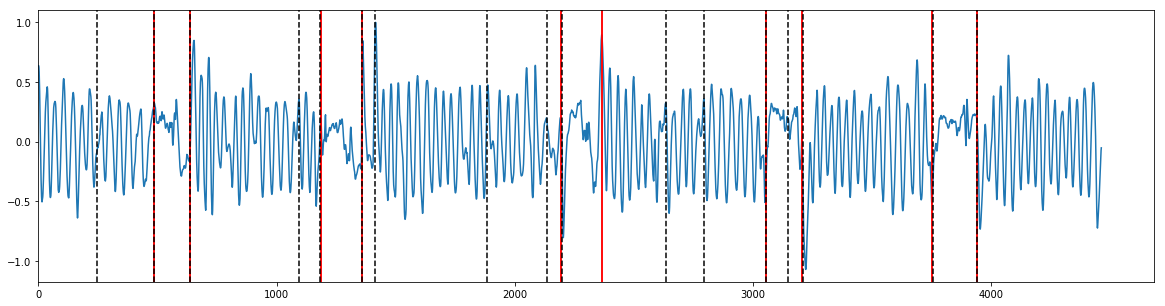

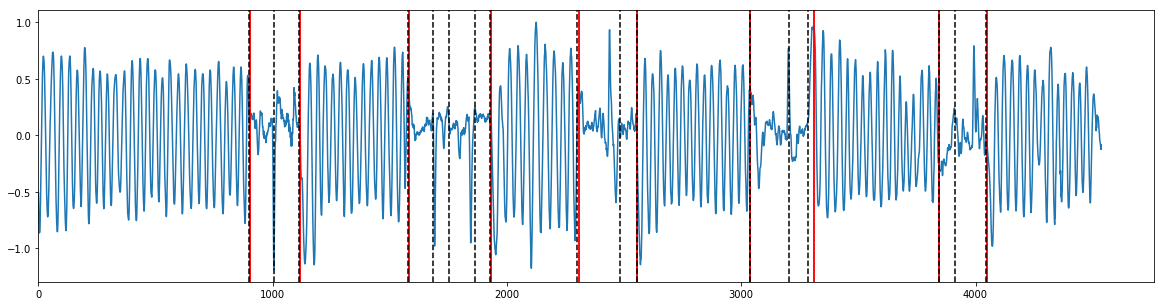

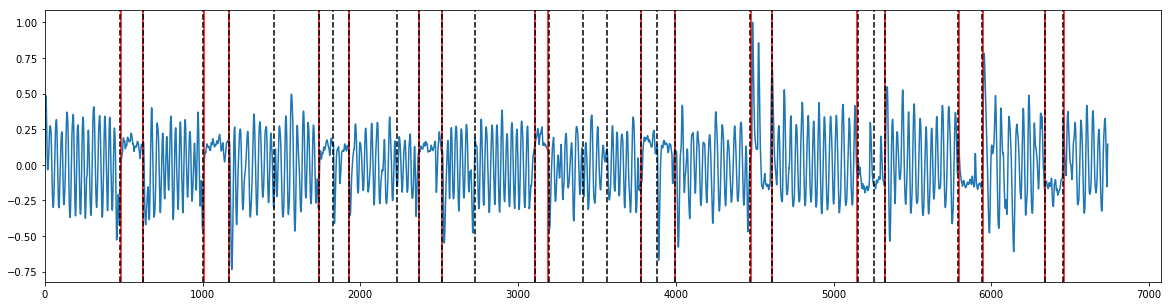

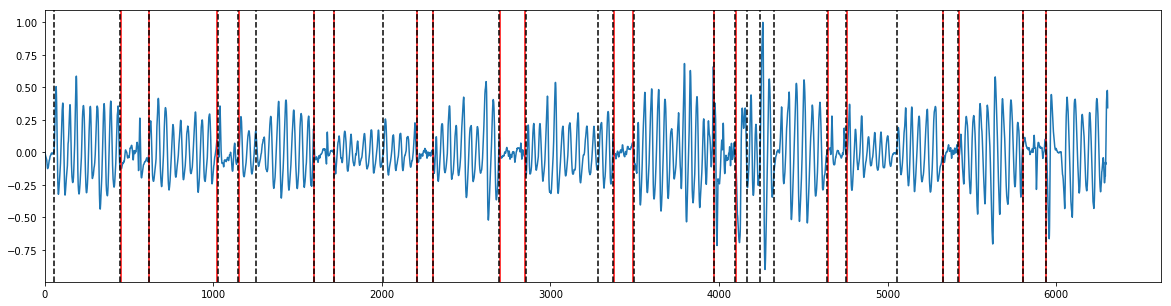

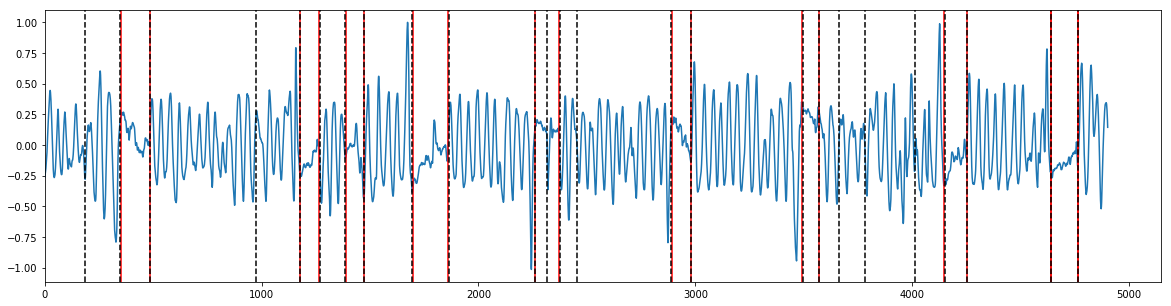

In [18]:
for j in range(30):
    plt.figure(figsize=(20,5))
    ax = plt.plot(v[j].T)
    plt.xlim(xmin=0)
    xcoords = a[j]
    for xc in xcoords:
        plt.axvline(x=xc,color='red')
    for i in range(len(v_final[j])):
        if(v_final[j][i] > 0):
            plt.axvline(x=i,color='black', linestyle='--')


In [19]:
a_final =  []
for i in range(30):
    a_final.append([])
    for j in range(len(v_final[i])):
        if(v_final[i][j] > 0):
            a_final[i].append(j)


In [20]:
s = 0
maxm = 0
minm = 1
for i in range(30):
    m = accuracy(a_final[i], a[i])
    maxm = max(maxm, m)
    minm = min(minm, m)
    s += m
print(s/30)
print(maxm)
print(minm)

0.6269823585943716
0.8636363636363636
0.35555555555555557
